In [1]:
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np                # linear algebra
from numpy.random import seed
from numpy.random import rand
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras import losses, optimizers
from keras.utils import to_categorical

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
class Particle:
    
    def __init__(self, weights, velocity, omega, c1, c2, 
                 lower_bound, upper_bound, particle_id):
        self.id = particle_id
        self.weights = weights
        self.best_weights = weights
        self.velocity = np.array(velocity)
        self.omega = omega
        self.c1 = c1
        self.c2 = c2
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.best_valuation = 0
        self.history = []
        
    def update(self, best_particle):
        self.update_velocity(best_particle)
        self.check_velocity()
        self.update_particle()
        # self.check_weights()
        
        return self.weights
    
    def update_velocity(self, bp):
        # v = Wv + c1r1(pi - xi) + c2r2(g - xi)
        # v        - ubrzanje 
        # W        - omega 
        # c1 i c2  - unapred zadati parametri
        # r1 i r2  - slucajni brojevi iz (0,1) uniformne raspodele
        # pi       - najbolje resenje trenutne jedinke
        # g        - najbojle globalno resenje
        r1 = np.random.random()
        r2 = np.random.random()
        
        self.velocity = self.omega * self.velocity + self.c1*r1*(np.add(np.array(self.best_weights), (-1)*np.array(self.weights))) + self.c2*r2*(np.add(np.array(bp), (-1)*np.array(self.weights))) 
        
    def check_velocity(self):
        for i in range(len(self.velocity)):
            if(i%2 == 1):
                for j in range(len(self.velocity[i])): 
                    if(self.velocity[i][j] < self.lower_bound):
                        self.velocity[i][j] = self.lower_bound
                    
                    if(self.velocity[i][j] > self.upper_bound): 
                        self.velocity[i][j] = self.upper_bound
            else: 
                for j in range(len(self.velocity[i])):
                    for k in range(len(self.velocity[i][j])):
            
                        if(self.velocity[i][j][k] < self.lower_bound):
                            self.velocity[i][j][k] = self.lower_bound
                
                        if(self.velocity[i][j][k] > self.upper_bound): 
                            self.velocity[i][j][k] = self.upper_bound
        
        return 
    
    
    def update_particle(self):
        # xi = xi + vi
        self.weights = np.add(np.array(self.weights), self.velocity)
        
    def update_valuation(self, valuation):
        self.history.append(valuation)
        
        if(valuation > self.best_valuation):
            self.best_valuation = valuation
            self.best_weights = self.weights
            
    def get_weights(self):
        return self.weights
    
    def set_weights(self, new_weights):
        self.weights = new_weights
    

In [3]:

class PSO:
    def __init__(self, num_particles, num_iters, training_x, training_y, model, shapes, c1, c2, w, lower_bound, upper_bound):
        self.num_iters = num_iters
        self.training_x = training_x
        self.training_y = training_y
        self.model = model
        self.best_particle = self.make_velocity(shapes)
        self.best_evaluation = 0
        self.history = []
        self.shapes = shapes
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.particles = self.make_particles(num_particles, shapes, c1, c2, w, lower_bound, upper_bound)
        self.evaluate_particles()
        self.combo = 0
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        
    def make_particles(self, size, shape, c1, c2, w, low, upp):
        particles = []
        
        velocity = self.make_velocity(shape)
        
        for i in range(size):
            weights = self.make_weights(shape, low, upp)
            particles.append(Particle(weights, velocity, w, c1, c2, low, upp, i))
            
        return particles
    
    def make_velocity(self, shapes):
        velocity = []
        
        for shape in shapes:
            velocity.append(np.zeros(shape))
        
        return velocity
                
        
    def make_weights(self, shapes, low, upp):
        weights = []
        
        for shape in shapes:
            if(len(shape) == 1):
                # wght da dobijemo vrednosti iz (0, upp-low)
                wght = rand(shape[0])*(upp-low)
                rec = np.full(shape, low)
                
                weights.append(np.add(wght, rec))
                
            else:
                wght = rand(shape[0], shape[1])*(upp-low)
                rec = np.full(shape, low)
                
                weights.append(np.add(wght, rec))
                
        return weights
        
        
    def evaluate_particles(self):
        
        for particle in self.particles:
            self.model.set_weights(particle.get_weights())
            train_loss, train_acc = self.model.evaluate(self.training_x, self.training_y, verbose = 0)
            
            particle.update_valuation(train_acc)
            
            if(train_acc > self.best_evaluation):
                self.best_particle = particle.get_weights()
                self.best_evaluation = train_acc
        
        
    def isclose(self, a, b, rel_tol=1e-09, abs_tol=0.0):
        return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)
    
    def update_particles(self):
        
        for particle in self.particles:
            particle.update(self.best_particle)
            
    def get_particles(self):
        return self.particles
    
    def start_pso(self):
        
        for i in range(self.num_iters):
            partly_best_solution = self.best_evaluation
            self.update_particles()
            self.evaluate_particles()
            
            #print("Iteracija: {}\nPreciznost: {}\n".format(i+1, self.best_evaluation))
            
            if(self.isclose(partly_best_solution, self.best_evaluation, 0.001)):
                self.combo += 1
            else:
                self.combo = 0
                
            if(self.combo == 5):
                self.particles.sort(key = lambda x: x.best_valuation)
                
                velocity = self.make_velocity(self.shapes)
                
                weights = self.make_weights(self.shapes, self.lower_bound, self.upper_bound)
                self.particles[0] = Particle(weights, velocity, self.w, self.c1, self.c2, 
                                             self.lower_bound, self.upper_bound, self.particles[0].id)
                
                weights = self.make_weights(self.shapes, self.lower_bound, self.upper_bound)
                self.particles[1] = Particle(weights, velocity, self.w, self.c1, self.c2, 
                                             self.lower_bound, self.upper_bound, self.particles[1].id)
                
                weights = self.make_weights(self.shapes, self.lower_bound, self.upper_bound)
                self.particles[2] = Particle(weights, velocity, self.w, self.c1, self.c2, 
                                             self.lower_bound, self.upper_bound, self.particles[2].id)
                
                weights = self.make_weights(self.shapes, self.lower_bound, self.upper_bound)
                self.particles[3] = Particle(weights, velocity, self.w, self.c1, self.c2, 
                                             self.lower_bound, self.upper_bound, self.particles[3].id)
                
                weights = self.make_weights(self.shapes, self.lower_bound, self.upper_bound)
                self.particles[4] = Particle(weights, velocity, self.w, self.c1, self.c2, 
                                             self.lower_bound, self.upper_bound, self.particles[4].id)
                self.combo = 0
                self.evaluate_particles()
                #print("Change bad particles")
            
            self.history.append(self.best_evaluation)   
                
                
            
        return self.best_particle

In [4]:
accs = []
print("IRIS DATASET: \n\n")
data1 = datasets.load_iris()

x_train, x_test, y_train, y_test = train_test_split(data1.data, 
                                                    data1.target, 
                                                    test_size=0.33)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# Pravljenje neuronske mreze sa 3 sloja - ulazni, skriveni i izlazni
model = Sequential()
model.add(Dense(units=100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.summary()

shapes = [i.shape for i in model.get_weights()]

model.compile(optimizer='adam', 
            loss=losses.categorical_crossentropy, 
            metrics=['accuracy'])

test_iris_acc = 0
train_iris_acc = 0
best_iris_pso = None

PSOS = []
for i in range(5):
    pso = PSO(30, 300, 
            x_train, y_train, 
            model, 
            shapes, 
            0.5, 1.0, 0.3, -2, 2)

    PSOS.append(pso)

for pso in PSOS:

    best_particle = pso.start_pso()

    model.set_weights(best_particle)

    train_loss, train_acc = model.evaluate(x_train, y_train)
    test_loss, test_acc = model.evaluate(x_test, y_test)

    if(test_iris_acc < test_acc): 
        test_iris_acc = test_acc
        best_iris_pso = pso
        train_iris_acc = train_acc
        
    print("Current PSO train accuracy: " + str(train_acc))
    print("Current PSO test accuracy:   " + str(test_acc) + "\n")

print()
print("Global best accuracy: " + str(test_iris_acc))
accs.append((train_iris_acc, test_iris_acc))

IRIS DATASET: 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 0s 178us/step
Current PSO train accuracy: 0.949999988079071
Current PSO test accuracy:   0.9399999976158142

50/50 [==============================] - 0s 131us/step
Current PSO train accuracy: 0.9800000190734863
Current PSO test accuracy:   0.9800000190734863

50/50 [==============================] - 0s 166us/step
Current PSO train accuracy: 0.6600000262260437
Current PSO test accuracy:   0.6800000071525574

50/50 [==============================] - 0s 139us

In [ ]:
print("\n---------------------------------\nBREAST CANCER DATASET: \n\n")
data2 = datasets.load_breast_cancer()

x_train, x_test, y_train, y_test = train_test_split(data2.data, 
                                                    data2.target, 
                                                    test_size=0.33)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pravljenje neuronske mreze sa 3 sloja - ulazni, skriveni i izlazni
model = Sequential()
model.add(Dense(units=100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.summary()

shapes = [i.shape for i in model.get_weights()]

model.compile(optimizer='adam', 
            loss=losses.categorical_crossentropy, 
            metrics=['accuracy'])

test_cancer_acc = 0
train_cancer_acc = 0
best_cancer_pso = None

PSOS = []
for i in range(5):
    pso = PSO(30, 300, 
            x_train, y_train, 
            model, 
            shapes, 
            0.5, 1.0, 0.3, -2, 2)

    PSOS.append(pso)

for pso in PSOS:

    best_particle = pso.start_pso()

    model.set_weights(best_particle)

    train_loss, train_acc = model.evaluate(x_train, y_train)
    test_loss, test_acc = model.evaluate(x_test, y_test)

    if(test_cancer_acc < test_acc): 
        test_cancer_acc = test_acc
        train_cancer_acc = train_acc
        best_cancer_pso = pso

    print("Current PSO train accuracy: " + str(train_acc))
    print("Current PSO test accuracy:   " + str(test_acc) + "\n")

print()
print("Global best accuracy: " + str(test_cancer_acc))
accs.append((train_cancer_acc, test_cancer_acc))

In [ ]:
print("\n---------------------------------\nWINE DATASET: \n\n")
data3 = datasets.load_wine()

x_train, x_test, y_train, y_test = train_test_split(data3.data, 
                                                    data3.target, 
                                                    test_size=0.33)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Pravljenje neuronske mreze sa 3 sloja - ulazni, skriveni i izlazni
model = Sequential()
model.add(Dense(units=100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.summary()

shapes = [i.shape for i in model.get_weights()]

model.compile(optimizer='adam', 
            loss=losses.categorical_crossentropy, 
            metrics=['accuracy'])

test_wine_acc = 0
train_wine_acc = 0
best_wine_pso = None

PSOS = []
for i in range(5):
    pso = PSO(30, 300, 
            x_train, y_train, 
            model, 
            shapes, 
            0.5, 1.0, 0.3, -2, 2)

    PSOS.append(pso)

for pso in PSOS:

    best_particle = pso.start_pso()

    model.set_weights(best_particle)

    train_loss, train_acc = model.evaluate(x_train, y_train)
    test_loss, test_acc = model.evaluate(x_test, y_test)

    if(test_wine_acc < test_acc): 
        test_wine_acc = test_acc
        train_wine_acc = train_acc
        best_wine_pso = pso

    print("Current PSO train accuracy: " + str(train_acc))
    print("Current PSO test accuracy:   " + str(test_acc) + "\n")

print()
print("Global best accuracy: " + str(test_wine_acc))
accs.append((train_wine_acc, test_wine_acc))

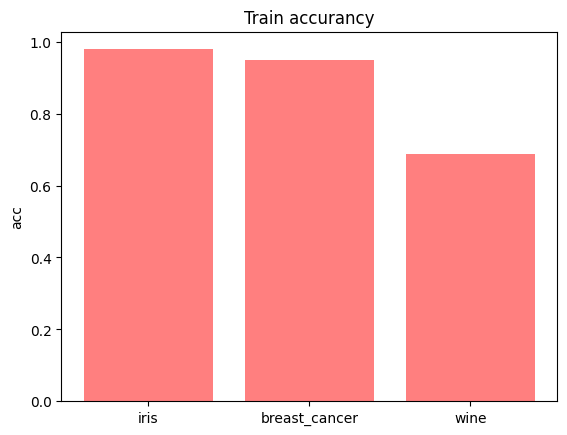

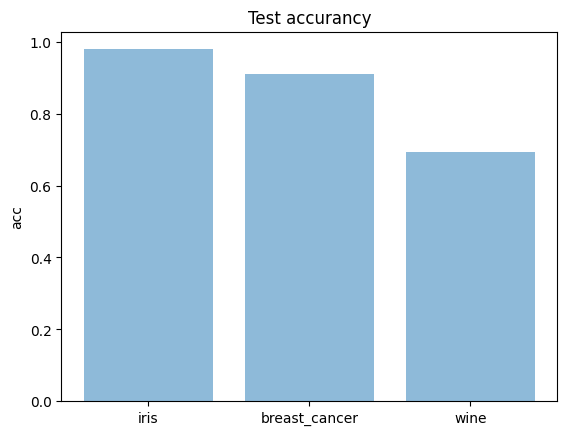

In [11]:
# Rezultati na sva 3 skupa za trening i test
import matplotlib.pyplot as plt; plt.rcdefaults()

objects = ('iris', 'breast_cancer', 'wine')
y_pos = np.arange(len(objects))

acc_train = [x[0] for x in accs] 
acc_test = [x[1] for x in accs]

# Trening
plt.bar(y_pos, acc_train, align='center', alpha=0.5, color = 'r')
plt.xticks(y_pos, objects)
plt.ylabel('acc')
plt.title('Train accurancy')

plt.show()

# Test
plt.bar(y_pos, acc_test, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('acc')
plt.title('Test accurancy')

plt.show()

Text(0.5, 1.0, 'Accurancy')

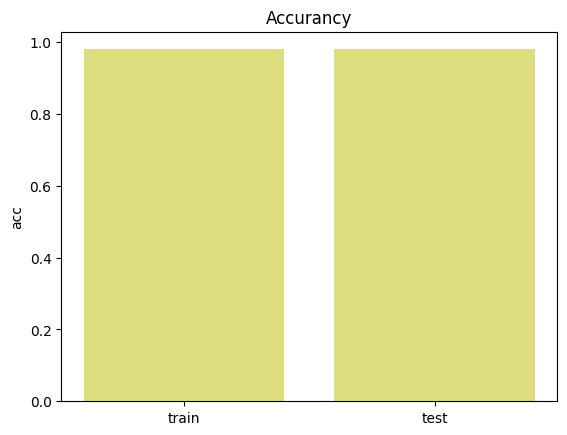

In [17]:
# Iris - poredjenje i nasi podaci
objects = ('train', 'test')
y_pos = np.arange(len(objects))

acc_of_iris = [] 
acc_of_iris.append(accs[0][0])
acc_of_iris.append(accs[0][1])  

# Trening
plt.bar(y_pos, acc_of_iris, align='center', alpha=0.5, color = 'y')
plt.xticks(y_pos, objects)
plt.ylabel('acc')
plt.title('Iris accurancy')

# TODO poredjenje + formula iz rada

Text(0.5, 1.0, 'Accurancy')

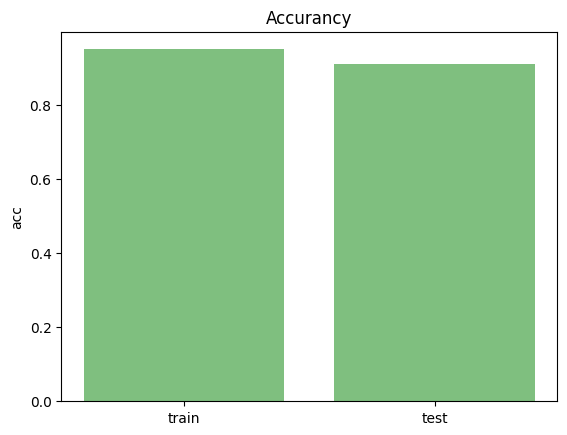

In [18]:
# Breast cancer - poredjenje i nasi podaci
objects = ('train', 'test')
y_pos = np.arange(len(objects))

acc_of_bc = [] 
acc_of_bc.append(accs[1][0])
acc_of_bc.append(accs[1][1])  

# Trening
plt.bar(y_pos, acc_of_bc, align='center', alpha=0.5, color = 'g')
plt.xticks(y_pos, objects)
plt.ylabel('acc')
plt.title('Breast cancer accurancy')

# TODO poredjenje

Text(0.5, 1.0, 'Accurancy')

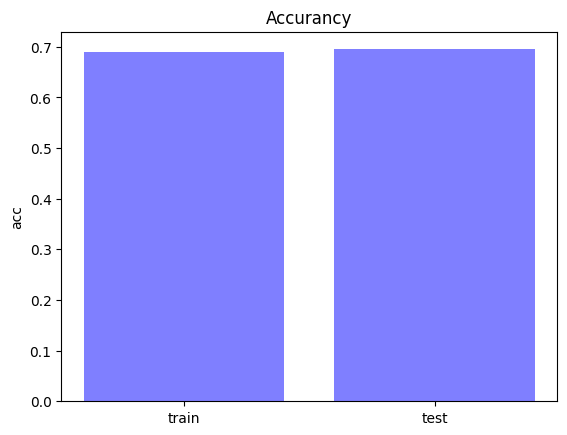

In [20]:
# Wine - poredjenje i nasi podaci
objects = ('train', 'test')
y_pos = np.arange(len(objects))

acc_of_w = [] 
acc_of_w.append(accs[2][0])
acc_of_w.append(accs[2][1])  

# Trening
plt.bar(y_pos, acc_of_w, align='center', alpha=0.5, color = 'b')
plt.xticks(y_pos, objects)
plt.ylabel('acc')
plt.title('Accurancy')

# TODO poredjenje